# Porto Seguro Exploratory Analysis and Prediction

참고 : https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

# 1st

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',100)

# 1. Exploring Data

## 1.1. Load the Data

In [9]:
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

## 1.2. Few quick observations

- 정의된 그룹은 거의 없으며 이러한 그룹에 속하는 변수에는 ind,reg,car,calc와 같은 이름 패턴이 있다. ind:individaul, reg:registration, car:car,calc:calculated field(계산된 변수)를 의미한다.
- 접두사 bin은 이진 변수에 쓰인다.
- 접두사 cat은 범주형 변수에 쓰인다.
- bin, cat이 없는 변수는 정수(연속값)나 실수(순서값)를 나타낸다.
- 결측값은 -1로 표시된다.
- 예측 대상인 값이 target 열에 있다. 이는 피보험자에 대해 청구가 되었는지를 나타낸다.
- id는 데이터 입력 순서형 숫자이다.

In [10]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


실제로 cat값은 0에서 n 사이 정수값인 범주형이고, bin값이 이진이라는 것을 알 수 있다.<br><br>
데이터의 행과 열의 수를 확인해보자.

In [11]:
print('Train dataset (rows,cols):',trainset.shape, '\nTest dataset (rows,cols):',testset.shape)

Train dataset (rows,cols): (595212, 59) 
Test dataset (rows,cols): (892816, 58)


train 데이터셋에 열이 59개, test 데이터셋에 58개가 있다. 데이터셋에서 target값을 뺀 것이다. 모두 괜찮은 것인지 두 데이터셋의 열의 차이를 확인해보자.

In [13]:
print('Columns in train and not in test dataset',set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset {'target'}


## 1.3. Introduction of metadata

데이터를 더 쉽게 조작하기 위해, trainset 변수에 대한 몇 가지 정보를 연결한다. 분석, 검토, 모델링을 위한 다양한 유형의 변수를 쉽게 선택할 수 있다. 또한 car, ind, reg, calc 유형의 변수를 category 변수로 사용한다.<br><br>
사용될 메타 데이터
- use : input, ID, target
- type : nominal, interval, ordinal, binary
- preserve : True or False (변수 보존 유무)
- dataType : int, float, char
- category : ind, reg, car, calc

In [16]:
data = []

for feature in trainset.columns:
    # use 정의
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # type 정의
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype,float):
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
        
    # id 제외 모든 변수에 preserve를 True로 초기화
    preserve = True
    if feature == 'id':
        preserve = False
        
    # 데이터유형 정의
    dtype = trainset[feature].dtype
    
    category = 'none'
    # category 정의
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    # 변수의 모든 메타데이터를 포함하는 딕셔너리 생성
    feature_dictionary = {
        'varname':feature, 'use':use, 'type':type,
        'preserve':preserve, 'dtype':dtype, 'category':category
    }
    data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname','use','type','preserve','dtype','category'])
metadata.set_index('varname',inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


이제 예를 들어 다음과 같이 범주형 값을 추출할 수 있다.

In [17]:
metadata[(metadata.type=='categorical')&(metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 변수를 검사해 category 값이 몇 개인지 알아보자.

In [20]:
pd.DataFrame({'count':metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


car 16개, individual 18개, registration 3개 등 총 계산된 20개의 변수가 있다. 이제 모든 변수를 검사해 use와 type 값이 몇 개인지 알아보자.

In [21]:
pd.DataFrame({'count':metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


nominal변수 1개(id), binary 20개, real(정수) 21개, 범주형 변수 16개가 있다. 이 모든 게 input값과 하나의 target 값이며, target값도 이항값이다.

# 2. Data analysis and statistics

## 2.1. Target variable

<Figure size 432x288 with 0 Axes>

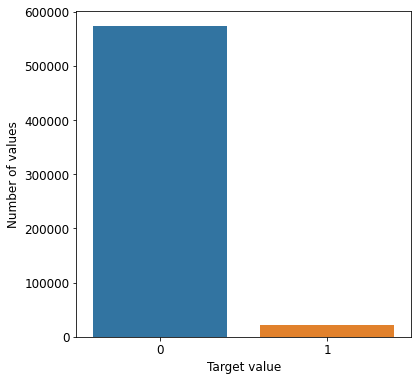

In [27]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
# target 평균의 내림차순 bar
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values',fontsize=12)
plt.xlabel('Target value',fontsize=12)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.show()

target 데이터의 3.64%만이 1 값을 갖는다. training 데이터셋이 아주 불균형하다는 의미다. target=0으로 언더샘플링하거나 target=1로 오버샘플링할 수 있다. 대규모 데이터셋이기 때문에 target=0으로 언더샘플링한다.

## 2.2. Real features

In [29]:
variable = metadata[(metadata.type=='real')&(metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [31]:
(pow(trainset['ps_car_12']*10, 2)).head(10)  ### pow(a,b) : a의 b승

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [33]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

ps_reg_03, ps_car_12, ps_car_14는 최소값 -1로 결측값을 갖는다.

### 2.2.1. Registration features

ps_reg_01, ps_reg_02는 분모가 10인 분수다.

### 2.2.2. Car features

ps_car_!2는 (근사치를 갖는) 자연수의 제곱근(10으로 나눈 값)이고, ps_car_15 또한 자연수의 제곱근이다. pairplot을 사용해 값을 확인해보자.

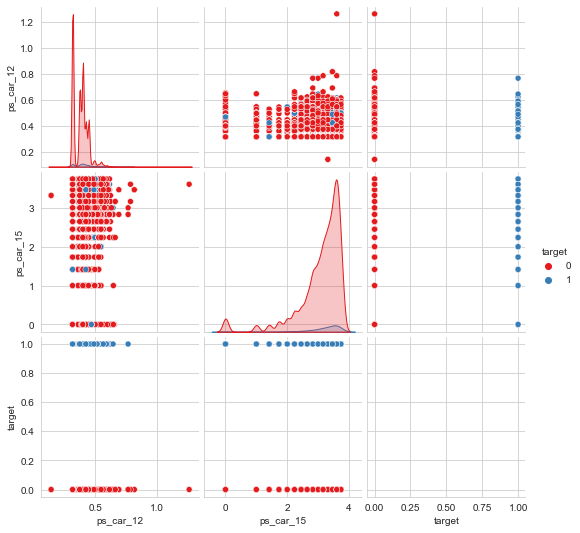

In [54]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12','ps_car_15','target']
sample = sample[var]
sns.pairplot(sample,hue='target',palette='Set1',diag_kind='kde',vars=var)
plt.show()

### 2.2.3. Calculated features

ps_calc_01, ps_calc_02, ps_calc_03 변수가 아주 유사한 분포를 가지고, 최대값이 모두 0.9이므로 일종의 비율일 수도 있다. 또 다른 calculated 값은 (5,6,7,10,12)의 정수인 최대값을 가진다.<br><br>
density plot을 사용해 real 변수를 시각화해보자.

<Figure size 432x288 with 0 Axes>

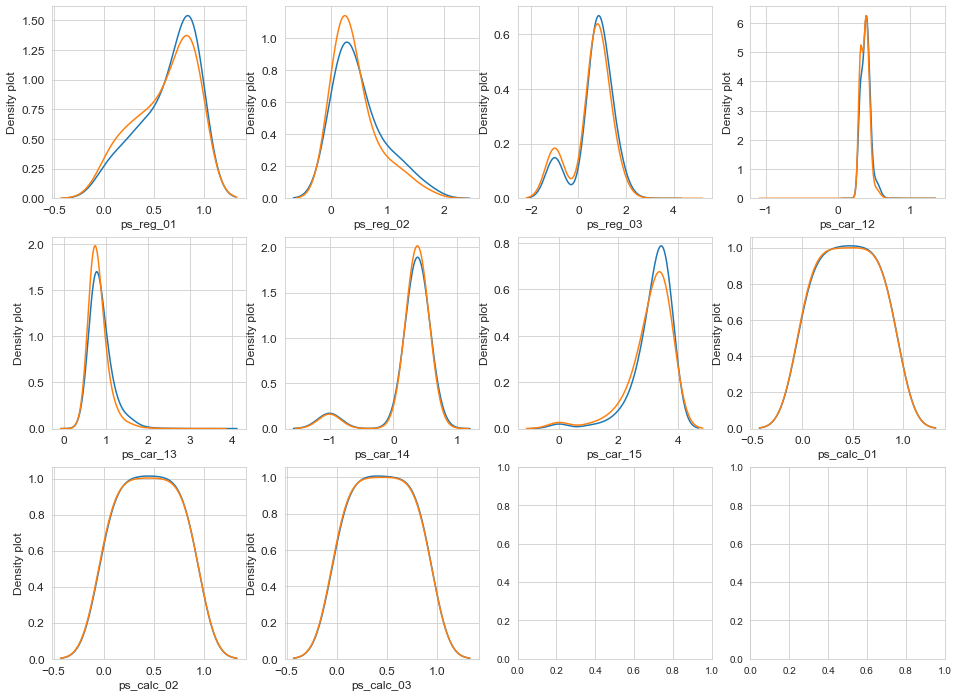

In [41]:
import warnings
warnings.filterwarnings('ignore')

var = metadata[(metadata.type=='real')&(metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_reg_02, ps_car_13, ps_car_15은 target=0과 target=1과 관련된 값들간 가장 다른 분포를 보인다.<br><br>
real 변수간 상관관계를 시각화해보자.

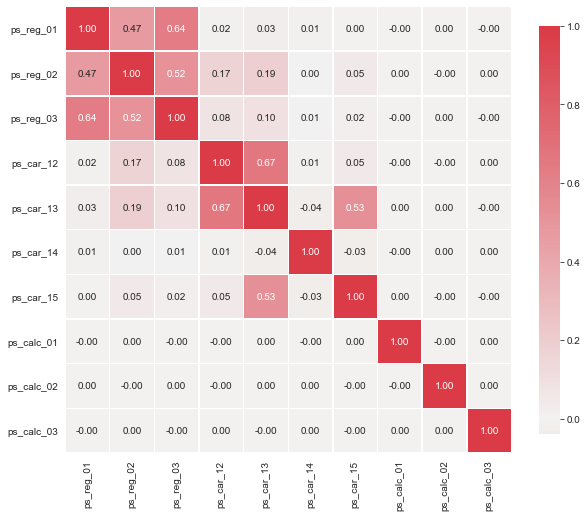

In [43]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # 두 색상간 범위가 있는 color map 생성
    cmap = sns.diverging_palette(50,10,as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show();
    
var = metadata[(metadata.type=='real')&(metadata.preserve)].index
corr_heatmap(var)

아래와 같이 강한 상관관계를 갖는 변수간 plot을 시각화해보자. 
- ps_reg_01, ps_reg_02 (0.47)
- ps_reg_01, ps_reg_03 (0.64)
- ps_reg_02, ps_reg_03 (0.52)
- ps_car_12, ps_car_13 (0.67)
- ps_car_13, ps_car_15 (0.53)

상관관계가 있는 변수의 쌍을 보기 위해 pairplot을 사용한다. 시각화하기 전에 sample에서 5%만 사용하여 데이터를 하위샘플로 추출한다.

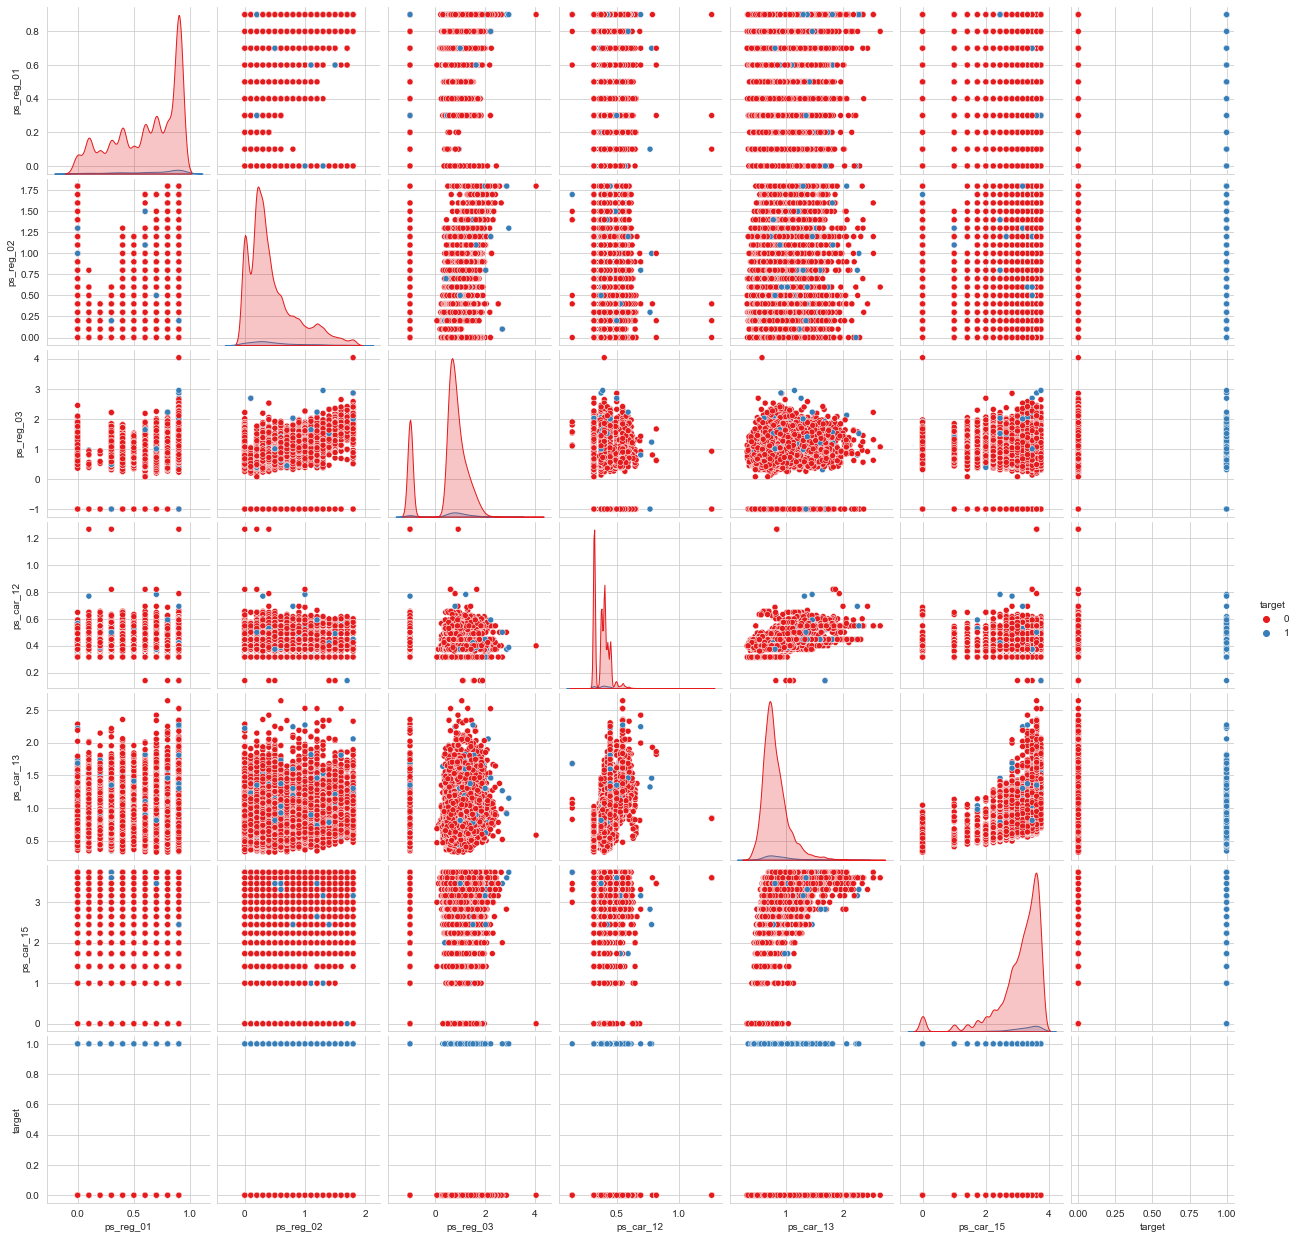

In [53]:
sample = trainset.sample(frac=0.05)  ### 설정된 frac 비율로 샘플 추출
var = ['ps_reg_01','ps_reg_02','ps_reg_03','ps_car_12','ps_car_13','ps_car_15','target']
sample = sample[var]

sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde',vars=var)
plt.show()

## 2.3. Binary features

In [ ]:
v = metadata[(metadata.type=='binary')&(metadata.preserve)].index
trainset[v].describe()

train 데이터셋에 있는 binary 데이터의 분포를 시각화해보자. 파란색은 0, 빨간색은 1의 비율을 나타낸다.

<Figure size 432x288 with 0 Axes>

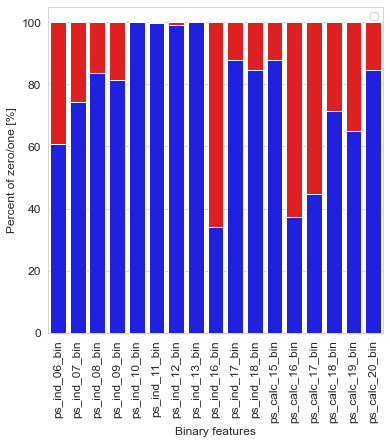

In [57]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum() / trainset.shape[0]*100) ### 0인 비율
    one_list.append((trainset[col]==1).sum() / trainset.shape[0]*100)  ### 1인 비율

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red') ### bottom: 0 비율이 아래로

plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1,p2),('Zero','One'))
plt.show()

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 1값 비율이 너무 작다(0.5%보다 작다). 반면 ps_ind_16_bin, ps_calc_16_bin은 1값 비율이 크다(60%보다 크다).<br><br>
binary 데이터의 분포와 target 값을 살펴보자.

<Figure size 432x288 with 0 Axes>

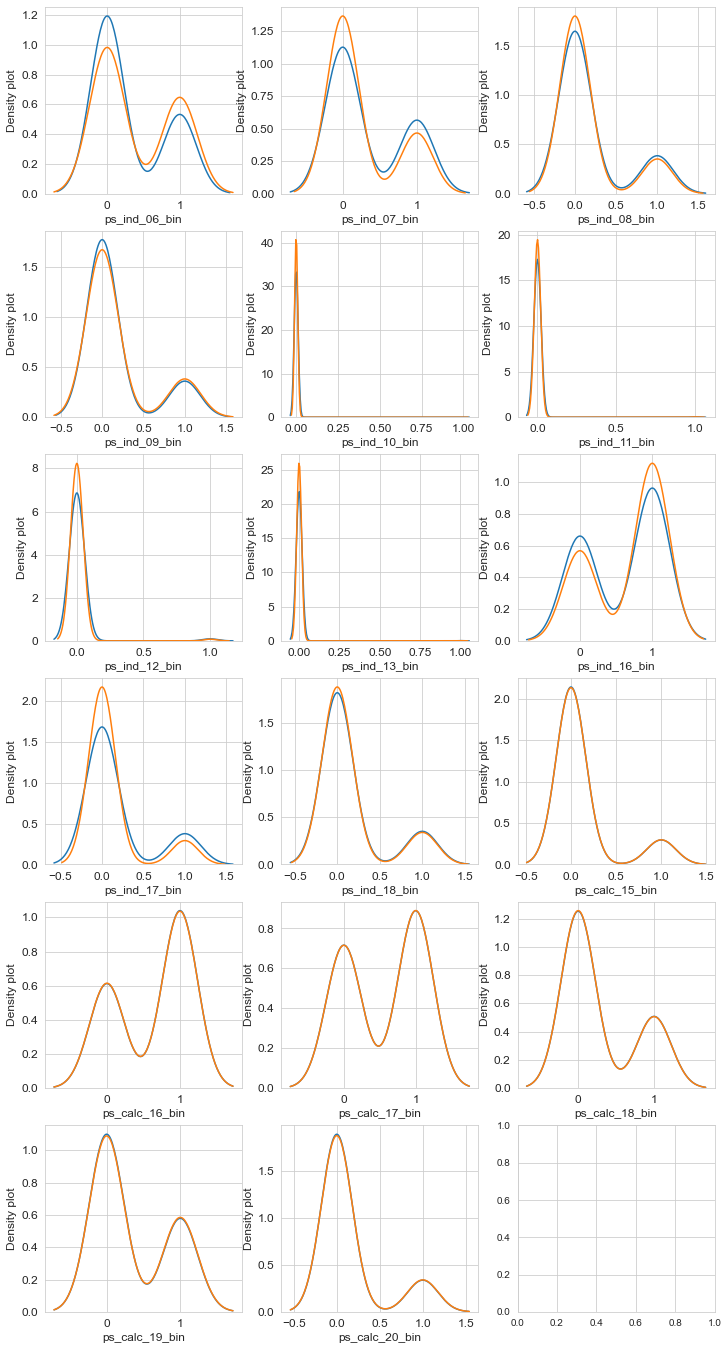

In [59]:
var = metadata[(metadata.type=='binary')&(metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target=1")
    sns.kdeplot(t0[feature], bw=0.5, label="target=0")
    
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin이 1과 0값 간 불균형이 심하고, target은 비슷하고, ps_ind_08_bin은 약간 불균형하다. 반면 다른 변수들은 균형이 잘 맞고 비슷한 분포를 보인다.

## 2.4. Categorical features

categorical 데이터를 두 방법으로 분포를 나타내보자. 먼저 범주 값당 target=1인 비율을 계산하고 bar plot을 사용해 비율을 나타낸다.

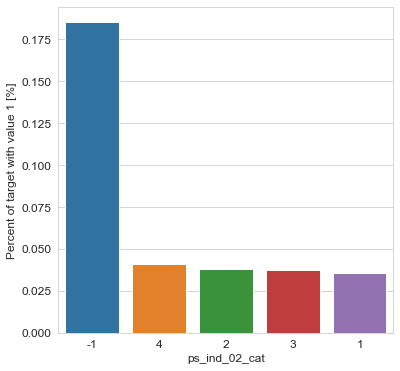

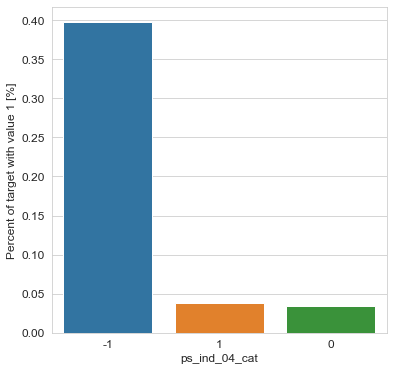

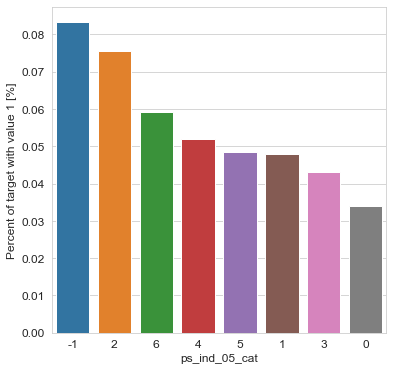

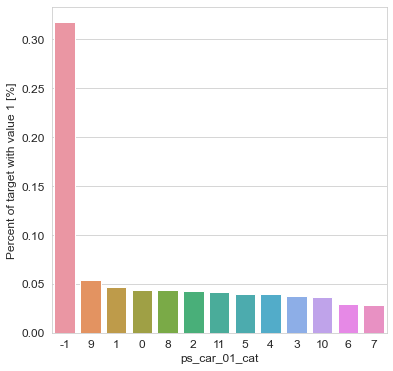

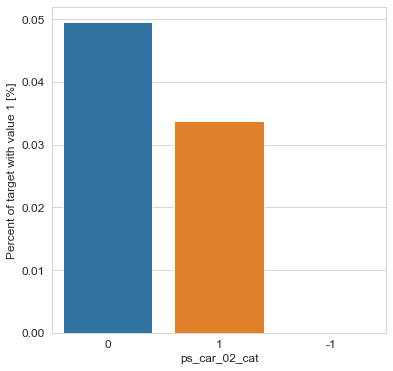

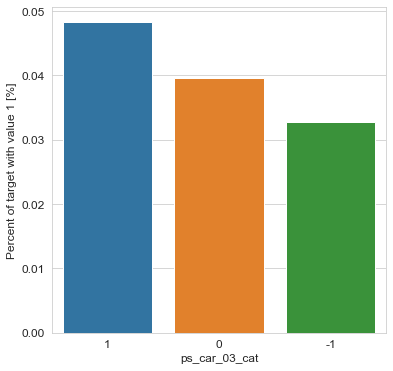

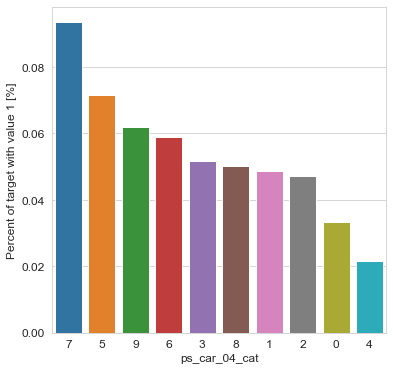

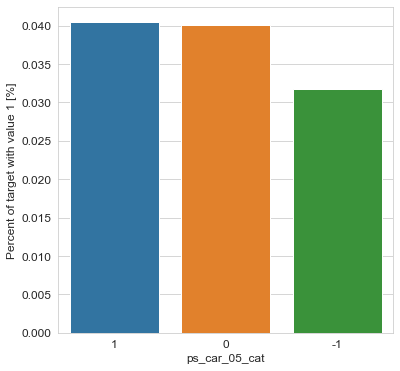

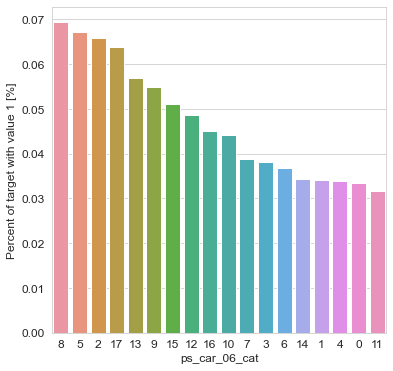

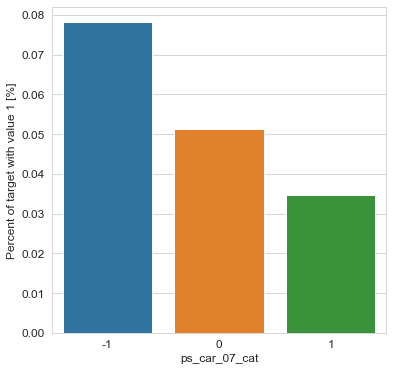

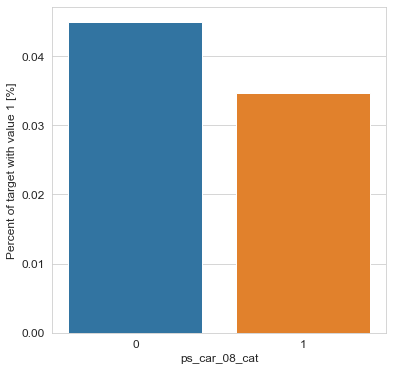

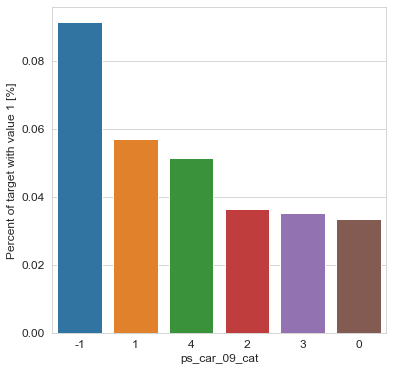

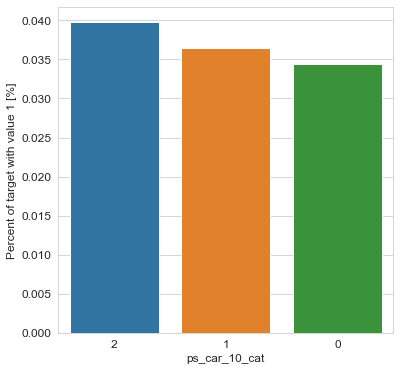

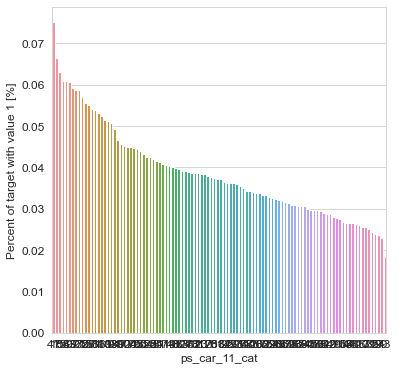

In [60]:
var = metadata[(metadata.type=='categorical')&(metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    
    # 범주 값당 target=1 비율 계산
    cat_perc = trainset[[feature,'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # Bar plot
    # target 평균을 내림차순 정렬한 bar
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

density plot을 사용해 categorical 변수를 나타낼 수도 있다. target=1, target=0으로 값을 선택하고 density plot을 같은 그래픽으로 나타낸다.

<Figure size 432x288 with 0 Axes>

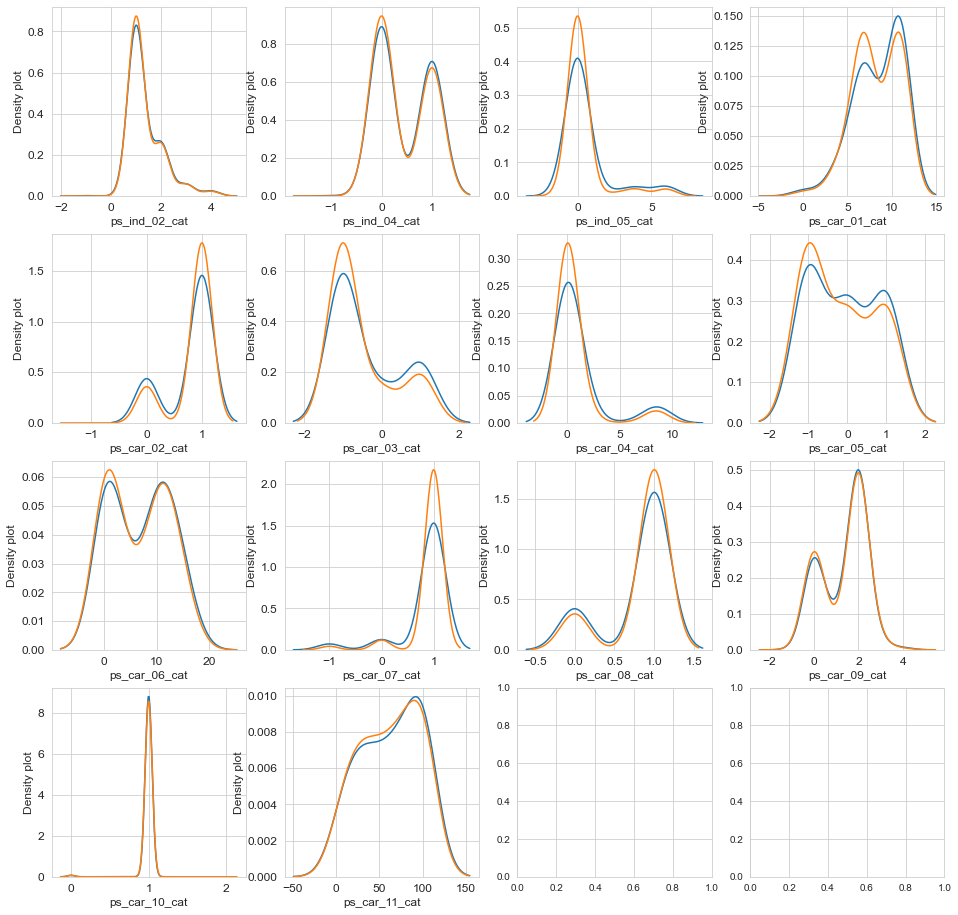

In [61]:
var = metadata[(metadata.type=='categorical')&(metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ps_car_03_cat, ps_car_05_cat이 target=0, target=1 값간 밀도 차이가 많이 난다.

## 2.5. Data unbalance between train and test data

train 과 test 데이터셋 변수의 분포를 비교해보자. reg나 registration 변수부터 시작한다.

<Figure size 432x288 with 0 Axes>

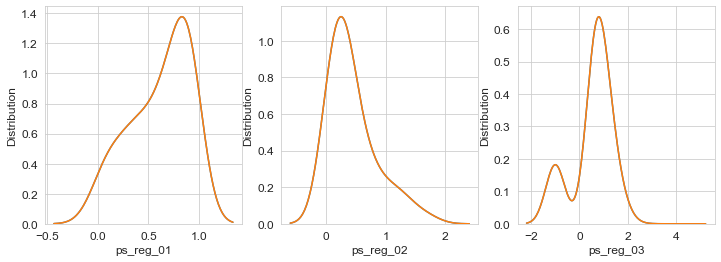

In [62]:
var = metadata[(metadata.category=='registration')&(metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0

for feature in var:
    i += 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(trainset[feature], bw=0.5, label='test')
    
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

모든 reg 변수가 train, test 데이터셋의 균형이 잘 맞는 것으로 보인다. car 변수로 계속해보자.

<Figure size 432x288 with 0 Axes>

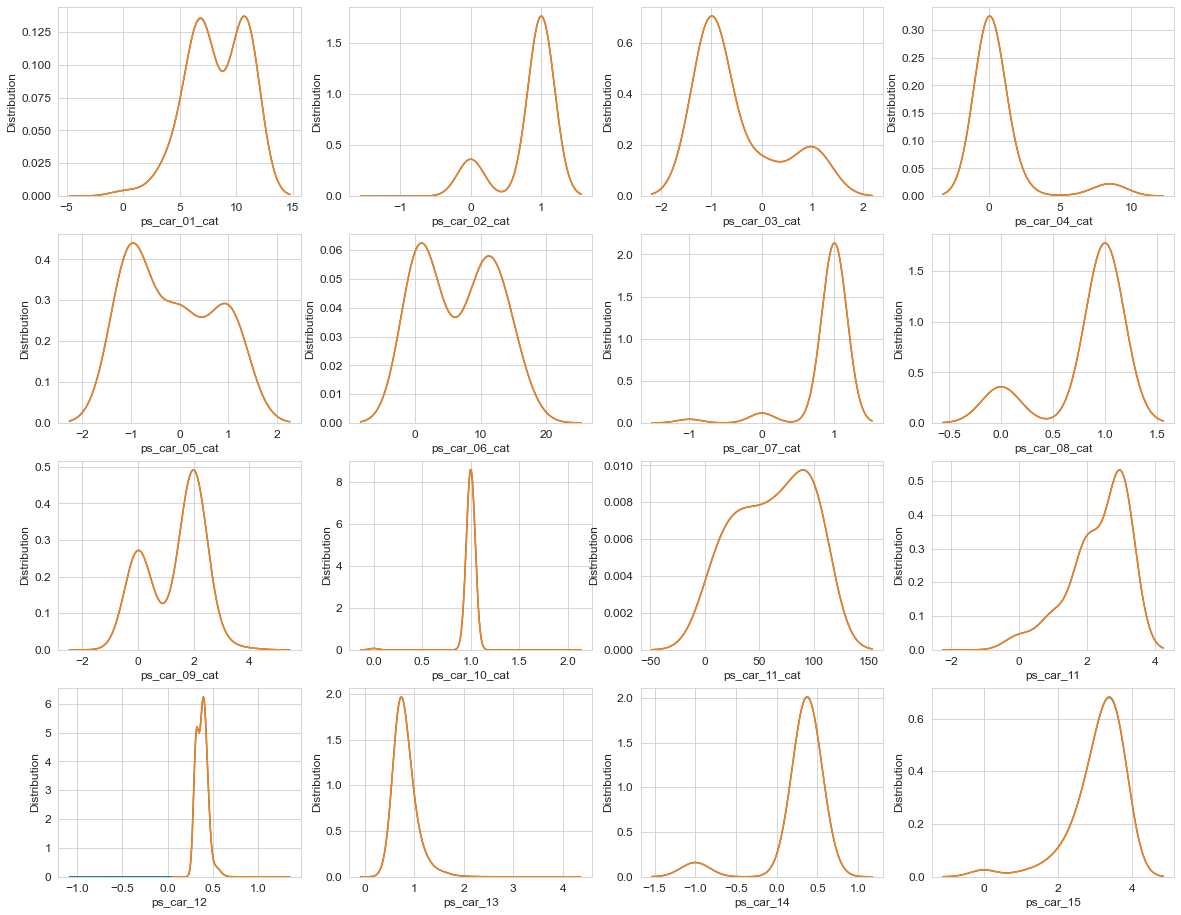

In [64]:
var = metadata[(metadata.category=='car')&(metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

car 변수인 모든 변수가 train, test 데이터셋의 균형이 잘 맞는 것으로 보인다. ind(individual) 값으로 계속해보자.

<Figure size 432x288 with 0 Axes>

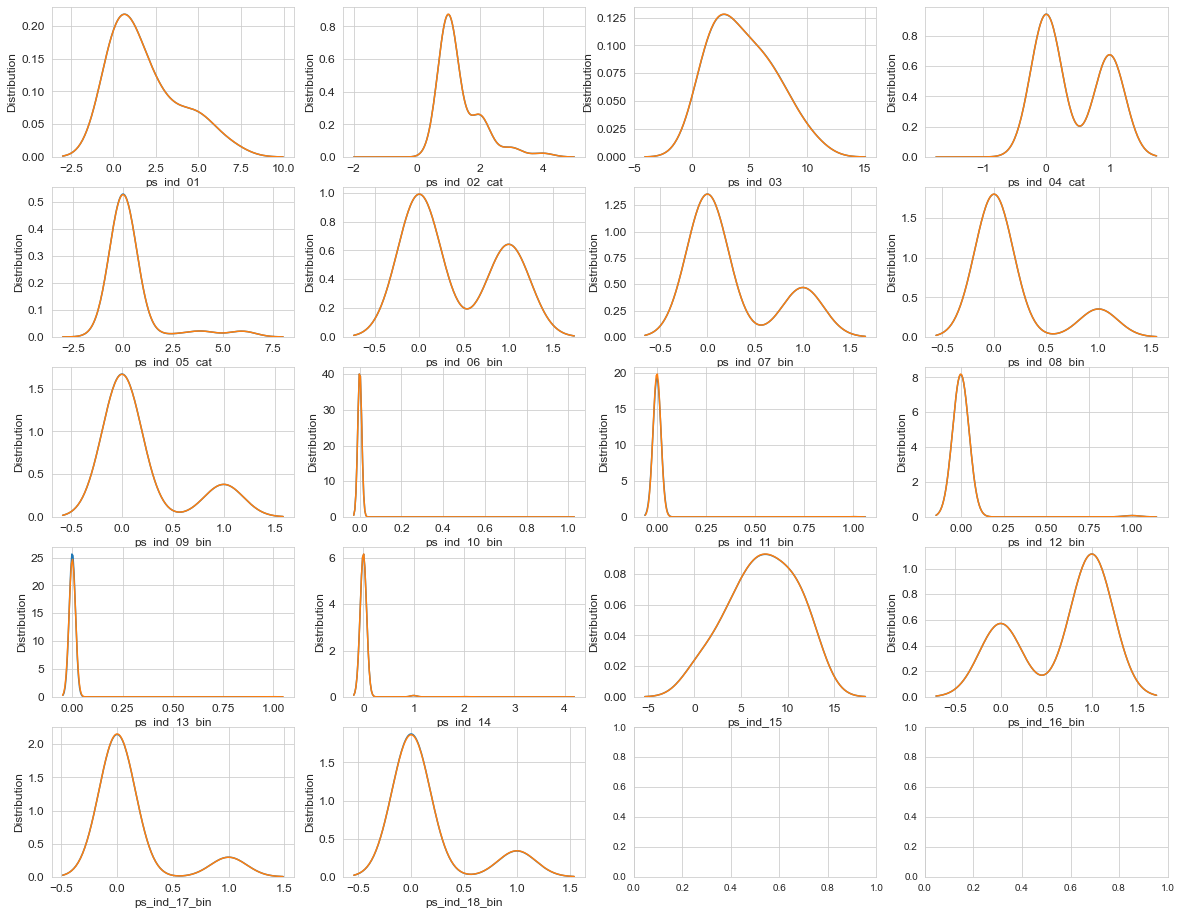

In [65]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

모든 ind 변수도 train, test 데이터셋의 균형이 잘 맞다. calc 변수도 확인해보자.

<Figure size 432x288 with 0 Axes>

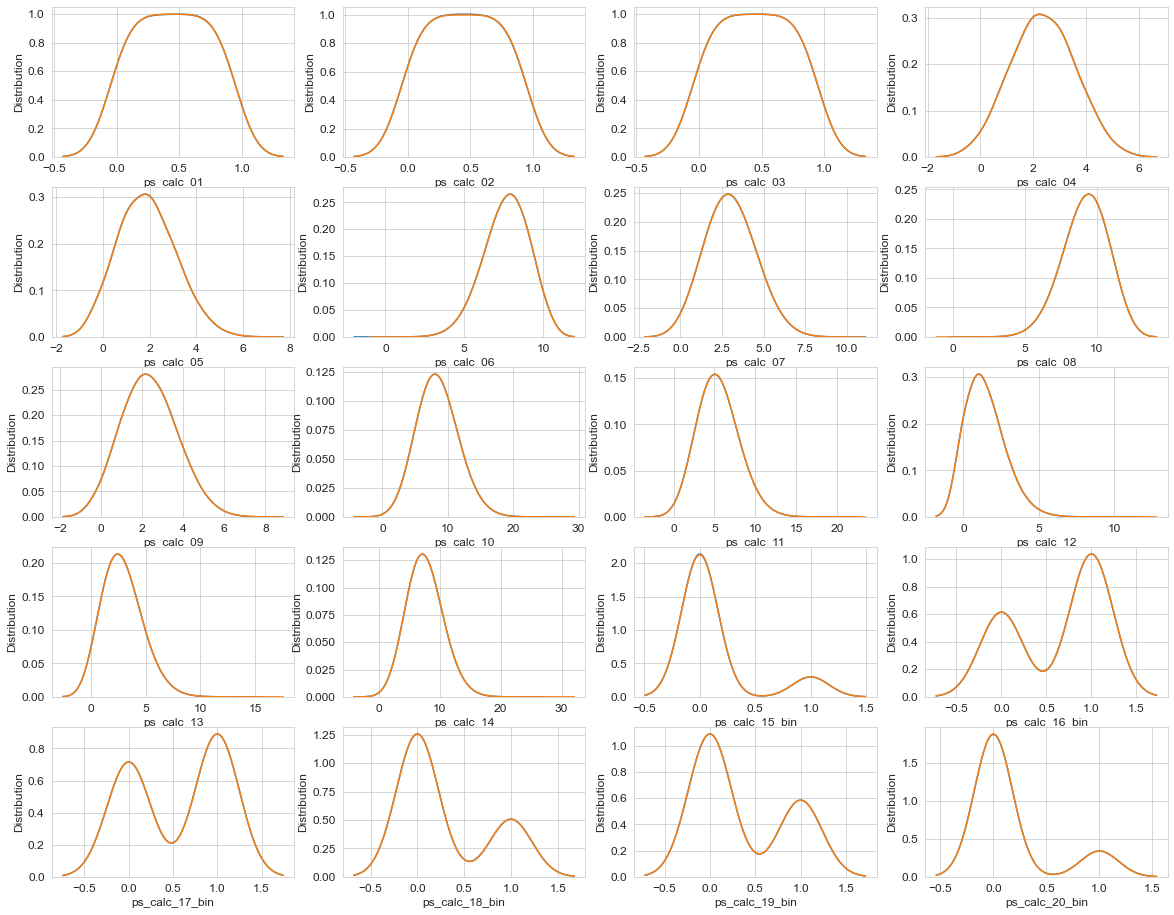

In [67]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 calc 변수가 train, test 데이터셋의 균형이 잘 맞는다. <br><br>
calc 변수가 모두 engineering 되었고 실제로 관련이 없을 수도 있다. 이것은 하나 이상의 예측 모델을 사용해 CV score를 통해 연속적인 제거를 해서만 평가할 수 있다.

## 2.6. Check data quality

결측값이 있는 변수를 확인해보자.

In [71]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature]==-1][feature].count()  ### 결측값 수
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]  ### 결측값 비율
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature,missings,missings_perc))

print('\nIn total, there are {} variables with missings values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missings values


# 3. Prepare the data for model

## 3.1. Drop calc columns

calc 열을 삭제한다. 이 열들은 모두 engineering 된 것으로 보이고, Dmitry Altukhov에 따르면 CV score를 향상시키면서 성공적으로 모두 제거할 수 있다고 한다.

In [72]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

## 3.2. Drop variables with too many missing values

ps_car_03_cat, ps_car_05_cat 변수가 결측값이 많으므로 삭제한다.

In [73]:
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # meatdata 업데이트

In [74]:
def add_noise(series, noise_level):
    return series * (1 + noise_level*np.random.randn(len(series)))

def target_encode(trn_series=None, tst_series=None, target=None, min_samples_leaf=1,smoothing=1,noise_level=0):
    """
    trn_series, tst_series : train, test의 범주형 변수 Series
    target : target
    min_samples_leaf(int) : 범주 평균을 얻는 최소 샘플수
    smoothing(int) : 범주형 평균과 이전 값의 균형을 맞추는 smoothing 효과
    """
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # target 평균 계산
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # smoothing 계산
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 모든 target 데이터에 평균 함수 적용
    prior = target.mean()
    # count가 클수록 full_avg는 감소
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # train series에 평균 적용
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                             on=trn_series.name,how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원
    ft_trn_series.index = trn_series.index 
    
    # test series에 평균 적용
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                             on=tst_series.name,how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## 3.3. Replace ps_car_11 with encoded value

target_encode 함수를 사용해 train, test 데이터셋에서 ps_car_11_cat을 인코드된 값으로 대체한다.

In [75]:
train_encoded, test_encoded = target_encode(trainset['ps_car_11_cat'],testset['ps_car_11_cat'],
                                           target=trainset.target,min_samples_leaf=100,smoothing=10,noise_level=0.01)
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # meatadata 업데이트

testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

## 3.4. Balance target variable

target 값은 굉장히 불균형하다. target=0값을 언더샘플링하거나 target=1값을 오버샘플링해 해결할 수 있다. train 데이터셋이 크므로 언더샘플링을 적용한다.

In [77]:
desired_apriori = 0.10

# target값별 인덱스 
idx_0 = trainset[trainset.target==0].index
idx_1 = trainset[trainset.target==1].index

# target값별 원데이터 수
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# 언더샘플링 비율과 target=0인 결과 레코드 수 계산
undersampling_rate = ((1-desired_apriori)*nb_1) / (nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# desired_priori 비율로 맞추기 위해 target=0인 레코드 랜덤 선택
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# 남은 인덱스 list로 저장
idx_list = list(undersampled_idx) + list(idx_1)

# 언더샘플링된 데이터프레임 반환
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## 3.5. Replace -1 values with NaN

우리가 사용할 대부분의 분류기가 결측값(NaN)을 처리하는 좋은 기능을 갖고있다.

In [78]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

## 3.6. Dummify cat values

categorical(cat) 변수에서 더미변수를 생성한다.

In [79]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp], axis=1)
    testset = testset.drop([column], axis=1)

## 3.7. Drop unused and target columns

id와 target을 분리한다.

In [80]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis=1)
testset = testset.drop(['id'], axis=1)

train과 test 데이터셋을 확인해보자.

In [84]:
print('Train dataset (rows, cols):', trainset.values.shape,
     '\nTest dataset (rows, cols):', testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


# 4. Prepare the model

## 4.1. Ensable class for cross validation and emsamble

KFold로 데이터를 나누기 위해 Emsamble 클래스를 준비하고, 모델을 학습시키고, 결과를 앙상블한다.<br>
클래스는 다음과 같은 4개의 파라미터가 있는 init 메소드를 갖는다. (Ensamble 객체를 만들 때 호출한다)
- self : 초기화될 객체
- n_splits : 교차검증 분리 수
- stacker : 학습된 기본 모델에서 예측 결과를 쌓을 때 사용되는 모델
- base_models : 학습에 사용될 기본 모델 리스트

두번째 메소드 fit_predict는 다음 기능을 갖는다.
- n_splits 폴드로 train 데이터를 분리
- 각 fold로 base models를 작동
- 각 모델을 사용해 예측
- stacker를 사용해 결과 앙상블

In [85]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X,y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx,test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print('Base model %d: fit %s model | fold %d'%(i+1, str(clf).split('(')[0], j+1))
                
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print('cross_score [roc-auc]: %.5f [gini]: %.5f'%(cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:,i] = S_test_i.mean(axis=1)
            
        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        
        # gini 계산 : 2*AUC-1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

## 4.2. Parameters for the base models

In [86]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

## 4.3. Initialize the models with the parameters

In [87]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

## 4.4. Initialize the ensambling object

In [88]:
stack = Ensemble(n_splits=3, stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

# 5. Run the predictive models

In [ ]:
y_prediction = stack.fit_predict(trainset, target_train, testset)    

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63727 [gini]: 0.27454
Base model 1: fit LGBMClassifier model | fold 2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63905 [gini]: 0.27811
Base model 1: fit LGBMClassifier model | fold 3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored.

[22:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_threads } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b

# 6. Prepare the submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)